# CSE527 Homework 3
**Due date: 23:59 on Oct 22, 2019 (Thuesday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Using SIFT in OpenCV 3.x.x in Colab
---
The default version of OpenCV in Colab is 3.4.3. If we use SIFT method directly, typically we will get this error message:

```
error: OpenCV(3.4.3) /io/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1207: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'

```

One simple way to use the OpenCV in-built function `SIFT` in Colab is to switch the version to the one from 'contrib'. Below is an example of switching OpenCV version:

1. Run the following command in one section in Colab, which has already been included in this assignment:
```
pip install opencv-contrib-python==3.4.2.16
```
2. Restart runtime by
```
Runtime -> Restart Runtime
```

Then you should be able to use use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object, whose functions are listed at http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html

## Some Resources
---
In addition to the tutorial document, the following resources can definitely help you in this homework:
- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
- http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
- http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html?highlight=sift#cv2.SIFT
- http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html


## Description
---
In this homework, we will examine the task of scene recognition starting with
very simple methods: tiny images and nearest neighbor classification, and then
move on to more advanced methods: bags of quantized local features and linear
classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

For this homework you will be implementing a basic bag of words model. You will
classify scenes into one of 16 categories by training and testing on the 16
scene database (introduced in [Lazebnik et al.
2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of
previously published datasets).
[Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great
paper to read, although we will be implementing the baseline method the paper
discusses (equivalent to the zero level pyramid) and not the more sophisticated
spatial pyramid. For an excellent survey of
pre-deep-learning feature encoding methods for bag of words models, see
[Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SIFT features, and 2 different classification techniques: nearest neighbor and linear SVM. There are 3 problems plus a performance report in this homework with a total of 100 points. 1 bonus question with extra 10 points is provided under problem 3. The maximum points you may earn from this homework is 100 + 10 = 110 points. Be sure to read **Submission Guidelines** below. They are important.

## Dataset
---

The starter code trains on 150 and tests on 50 images from each category (i.e. 2400
training examples total and 800 test cases total). In a real research paper,
one would be expected to test performance on random splits of the data into
training and test sets, but the starter code does not do this to ease debugging.

Save the [dataset(click me)](https://drive.google.com/drive/folders/1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M?usp=sharing) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.


## Starter Code
---
To make your task a little easier, below we provide some starter code which
randomly guesses the category of every test image and achieves about 6.25% accuracy
(1 out of 16 guesses is correct).

In [0]:
####################Doubts################3
#No. of test samples are 25 not 50 thus, total no. of test cases are 400.
#Do we need to add test and train in test set and then random split them?
#There are many design decisions and free parameters for the bag of SIFT representation (number of clusters, sampling density, sampling scales, SIFT parameters, etc.)

In [22]:
pip install opencv-contrib-python==3.4.2.16

In [23]:
# import packages here
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import itertools
import time
import zipfile
import torch
import torchvision
import gc
import pickle
from sklearn import svm
from skimage import color
from skimage import io
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
import time
import warnings

print(cv2.__version__) # verify OpenCV version

3.4.2


In [24]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
# Set your working directory (in your google drive)
# Note that 'gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/hw3' is just an example, 
#   change it to your specific homework directory.
cd 'gdrive/My Drive/CV/Rawat_Rohit_112963417_hw3/'

[Errno 2] No such file or directory: 'gdrive/My Drive/CV/Rawat_Rohit_112963417_hw3/'
/content/gdrive/My Drive/CV/Rawat_Rohit_112963417_hw3


## Data Preparation

In [26]:
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples_per_class = 150
n_test_samples_per_class = 50

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

# load training dataset
# train_data, train_label = load_dataset('./data/train/')
train_data, train_label = load_dataset('./data/train/', n_train_samples_per_class)
n_train = len(train_label)
print("n_train: %s" % n_train)

# load testing dataset
# test_data, test_label = load_dataset('./data/test/')
test_data, test_label = load_dataset('./data/test/', n_test_samples_per_class)
n_test = len(test_label)
print("n_test: %s" % n_test)

class_names: {0: 'Suburb', 1: 'InsideCity', 2: 'Street', 3: 'LivingRoom', 4: 'Office', 5: 'TallBuilding', 6: 'Kitchen', 7: 'OpenCountry', 8: 'Store', 9: 'Mountain', 10: 'Highway', 11: 'Forest', 12: 'Coast', 13: 'Bedroom', 14: 'Flower', 15: 'Industrial', 16: '_DS_Store'} 
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
n_train: 2400
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading ima

In [0]:
# As loading the data from the source for the first time is time consuming, so you can pkl or save the data in a compact way such that subsequent data loading is faster
# Save intermediate image data into disk
file = open('train.pkl','wb')
pickle.dump(train_data, file)
pickle.dump(train_label, file)
file.close()

file = open('test.pkl','wb')
pickle.dump(test_data, file)
pickle.dump(test_label, file)
file.close()

In [28]:
# Load intermediate image data from disk
file = open('train.pkl', 'rb')
train_data = pickle.load(file)
train_label = pickle.load(file)
file.close()

file = open('test.pkl', 'rb')
test_data = pickle.load(file)
test_label = pickle.load(file)
file.close()

print(len(train_data), len(train_label)) # Verify number of training samples
print(len(test_data), len(test_label))   # Verify number of testing samples

2400 2400
400 400


In [0]:
#plt.imshow(train_data[1], cmap='gray') # Verify image
img_new_size = (240, 240)

train_data = list(map(lambda x: cv2.resize(x, img_new_size), train_data))
#print('old',train_data)
train_data = np.stack(train_data)
#print('new',train_data)
train_label = np.array(train_label)
#print('new',train_label)

test_data = list(map(lambda x: cv2.resize(x, img_new_size), test_data))
test_data = np.stack(test_data)
test_label = np.array(test_label)
#plt.imshow(train_data[1], cmap='gray') # Verify image


In [0]:
# Verify image
#plt.imshow(cv2.resize(train_data[1], img_new_size), cmap='gray')
#print(train_data[1].dtype)
#print(train_data[0])

In [31]:
n_train = len(train_label)
n_test = len(test_label)

# feature extraction
def extract_feat(raw_data):
    print(len(raw_data))
    feat_dim = 1000
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in np.arange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
    print("feat",len(feat))
    
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(16) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in np.arange(n_test):
    predictions[i] = predict(None, test_feat[i])
    
accuracy = sum(np.array(predictions) == test_label) / float(n_test)

print("The accuracy of my dummy model is {:.2f}%".format(accuracy*100))

2400
feat 2400
400
feat 400
The accuracy of my dummy model is 6.00%


## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image to 16x16**. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [32]:
# Write your codes here
#plt.imshow(train_data[1], cmap='gray') # Verify image
img_new_size = (16, 16)
train_data1 = list(map(lambda x: cv2.resize(x, img_new_size).flatten(), train_data))

train_data1 = np.stack(train_data1)
train_data1 = train_data1 - np.mean(train_data1, axis = 1).reshape(-1,1)
square_train = train_data1**2
train_data1 = train_data1 / np.sqrt(np.sum(square_train, axis = 1).reshape(-1,1))
train_label1 = np.array(train_label)


test_data1 = list(map(lambda x: cv2.resize(x, img_new_size).flatten(), test_data))
test_data1 = np.stack(test_data1)
test_data1 = test_data1 - np.mean(test_data1, axis = 1).reshape(-1,1)
square_test = test_data1**2
test_data1 = test_data1 / np.sqrt(np.sum(square_test, axis = 1).reshape(-1,1))
label1 = np.array(test_label)

start = time.process_time()
classifier = KNeighborsClassifier(n_neighbors=1, metric = 'minkowski', p=2)
classifier.fit(train_data1, train_label1)
time1 = time.process_time() - start
print("Time Consumption in Training (Tiny Image Representation + Nearest Neighbor Classifier) : ",time1 , "seconds")

start = time.process_time()
pred1 = classifier.predict(test_data1)
time2 = time.process_time() - start

print("The accuracy of this model is {:.2f}%".format(accuracy_score(label1,pred1)*100)) 
print("Time Consumption in Prediction (Tiny Image Representation + Nearest Neighbor Classifier) : ",time2, "seconds")

Time Consumption in Training (Tiny Image Representation + Nearest Neighbor Classifier) :  0.019340334999998987 seconds
The accuracy of this model is 23.00%
Time Consumption in Prediction (Tiny Image Representation + Nearest Neighbor Classifier) :  0.5613888439999997 seconds


## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{35 points}
After you have implemented a baseline scene recognition pipeline it is time to
move on to a more sophisticated image representation — bags of quantized SIFT
features. Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. Because it can be slow to sample and
cluster many local features, the starter code saves the cluster centroids and
avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 220. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

After you obtain the Bag of SIFT feature representation of the images, you have to
train a KNN classifier in the Bag of SIFT feature space and report your test set accuracy and time consumption. 

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to densely sample keypoints in a grid with certain step
  size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary from 50% to 60%.
- Indicate clearly the parameters you use along with the prediction accuracy
  on test set and time consumption.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints
  ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).
- Be mindful of RAM usage. Try to make the code more memory efficient, otherwise it could easily exceed RAM limits in Colab, at which point your session will crash.
- If your RAM is going to run out of space, use [gc.collect()](https://docs.python.org/3/library/gc.html) for the garbage collector to collect unused objects in  memory to free some space.
- Store data or features as NumPy arrays instead of lists. Computation on NumPy arrays is much more efficient than lists.

In [33]:
import gc
gc.collect()

244

In [0]:
train_data_2 = train_data.copy()
test_data2 = test_data.copy()
train_label2 = train_label.copy()
label2 = test_label.copy()
no_of_clusters = 50


In [0]:
def clustering(image_list):
  desc_list = []
  for img in image_list:
    extractor = cv2.xfeatures2d.SIFT_create()
    kp = extractor.detect(img)
    dkp = [cv2.KeyPoint(k.pt[0], k.pt[1],k.size) for k in kp]
    keyp, descriptors = extractor.compute(img, dkp)
    desc_list.append(descriptors)
    
  desc_list=np.asarray(desc_list)
  desc_list=np.concatenate(desc_list, axis=0)
  #desc_list = np.sqrt(desc_list).astype(int)

  
  kmeans = MiniBatchKMeans(n_clusters=50, random_state=0).fit(desc_list)
  
  return kmeans
  

In [0]:
def histogram(image_list,kmeans):
  features = []
  for img in image_list:
    extractor = cv2.xfeatures2d.SIFT_create()
    ###
    kp = extractor.detect(img)
    dkp = [cv2.KeyPoint(k.pt[0], k.pt[1],k.size) for k in kp]
    keyp, descriptors = extractor.compute(img, dkp)
    ###
    #kp, descriptors = extractor.detectAndCompute(img,None)
    predict_class = kmeans.predict(descriptors)
    hist, bin_edges=np.histogram(predict_class, bins=50)
    
    features.append(hist)
    
  features=np.asarray(features)
  return features

In [41]:
start = time.process_time()
kmeans = clustering(train_data_2)
time7 = time.process_time() - start
print("Time Consumption for Clustering Features: ",time7 , "seconds")


Time Consumption for Clustering Features:  276.344156119 seconds


In [42]:
start = time.process_time()
train_feat = histogram(train_data_2,kmeans)
test_feat = histogram(test_data2,kmeans)
time8 = time.process_time() - start
print("Time Consumption for Histogram Generation: ",time8 , "seconds")


Time Consumption for Histogram Generation:  358.16528853899996 seconds


In [43]:
start = time.process_time()
classifier = KNeighborsClassifier(n_neighbors=10, metric = 'minkowski', p=2)
classifier.fit(train_feat, train_label2)
time3 = time.process_time() - start

print("Time Consumption in Training (Bag of SIFT Representation + Nearest Neighbor Classifer) : ",time3 , "seconds")

start = time.process_time()
pred2 = classifier.predict(test_feat)
time4 = time.process_time() - start
print("The Prediction accuracy of this model is {:.2f}%".format(accuracy_score(label2,pred2)*100)) 

print("Time Consumption in Prediction (Bag of SIFT Representation + Nearest Neighbor Classifer) : ",time4 , "seconds")


Time Consumption in Training (Bag of SIFT Representation + Nearest Neighbor Classifer) :  0.011330282000017178 seconds
The Prediction accuracy of this model is 46.75%
Time Consumption in Prediction (Bag of SIFT Representation + Nearest Neighbor Classifer) :  0.2227230559999498 seconds


## Problem 3.a: Bag of SIFT Representation + one-vs-all SVMs
{15 points}
The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT
feature space. Linear classifiers are one of the simplest possible learning
models. The feature space is partitioned by a learned hyperplane and test cases
are categorized based on which side of that hyperplane they fall on. Despite
this model being far less expressive than the nearest neighbor classifier, it
will often perform better.

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 16-way classification problem
(the library has handled it for you). To decide which of 16 categories a test
case belongs to, you will train 16 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'forest' vs 'non-forest',
'kitchen' vs 'non-kitchen', etc. All 16 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'forest' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
kitchen even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
$\lambda$ (lambda) which controls how strongly regularized the model is. Your
accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on
test set and time consumption.

**Bonus {10 points}**: For this question, you need to generate class prediction for the images in **test2** folder using your best model. The prediction file(**Surname_Givenname_SBUID_Pred.txt**) should follow the exact format as given in the **sample.txt** file.10 points will be given to students whose accuracy ranks top 3 in this homework.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [44]:
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#Standardizing the histogram matrix
train_featn = scaler.fit_transform(train_feat)
test_featn = scaler.fit_transform(test_feat)

label3 = test_label.copy()

start = time.process_time()
clf = svm.LinearSVC(random_state=0, C = 4.6)    #Using lambda = 4.6 
clf.fit(train_featn, train_label2) 
time5 = time.process_time() - start
print("Time Consumption in Training (Bag of SIFT Representation + one-vs-all SVMs) : ",time5 , "seconds")

start = time.process_time()
pred3 = clf.predict(test_featn)
time6 = time.process_time() - start
print("Using Lambda = 4.6")
print("The Prediction accuracy of this model is {:.2f}%".format(accuracy_score(label3,pred3)*100)) 
print("Time Consumption in Prediction (Bag of SIFT Representation + one-vs-all SVMs) : ",time6 , "seconds")


Time Consumption in Training (Bag of SIFT Representation + one-vs-all SVMs) :  3.4781483980000303 seconds
Using Lambda = 4.6
The Prediction accuracy of this model is 50.25%
Time Consumption in Prediction (Bag of SIFT Representation + one-vs-all SVMs) :  0.0008427019999999175 seconds


In [0]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts
  
def load_dataset_test2(path):
    data = []
    Names = []
    img_path_class = sorted(glob.glob(path + '/*.jpg'), key=numericalSort)
    for filename in img_path_class:
        data.append(cv2.imread(filename, 0))
        filename = filename[13:]
        filename,jpg = filename.split('.')
        imgn,file_number = filename.split('_')
        num = file_number.zfill(3)  
        filename = "{}_{}".format('img', num)
        Names.append(filename)
    return data,Names

# load training dataset
# train_data, train_label = load_dataset('./data/train/')

img_new_size = (240,240)
test2_data,Names = load_dataset_test2('./data/test2/')
test2_data = list(map(lambda x: cv2.resize(x, img_new_size), test2_data))
test2_data = np.stack(test2_data)

test2_feat = histogram(test2_data,kmeans)
test2_feat = scaler.fit_transform(test2_feat)

pred4 = clf.predict(test2_feat)


In [0]:
Names = np.array(Names)
pred4 = np.array(pred4)
#Names.reshape(-1,1)
Names = Names.flatten()

p=pd.DataFrame(Names, columns =['Name'])
p['Class_id'] = pred4
np.savetxt('Rawat_Rohit_112963417_Pred.txt', p.values, fmt='%s', header="Name Class_id", comments='')  


## Problem 3.b
{5 points} Repeat the evaluation above for different sizes of training sets and draw a plot to show how the size of the training set affects test performace. Do this for training set sizes of 800, 1200, 1600, 2000, 2200, and 2300 images. Randomly sample the images from the original training set and evaluate accuracy. Repeat this process 10 times for each training set size and report the average prediction accuracy. How does performance variability change with training set size? How does performance change? Give reason for your observations.

In [47]:
# Write your codes here
training_size = [800,1200,1600,2000,2200,2300]
Accuracy = []
Time_consum = []
#train_set=np.concatenate((train_data,train_label), axis=1) 
for tsize in training_size:
  A_score = 0.0
  start = time.process_time()
  for i in range(10):
      perm = np.random.permutation(np.arange(2400))
      ind = perm[0:tsize]
      feat = train_featn[ind]
      labels = train_label2[ind]
      clf_n = svm.LinearSVC(random_state=0, C = 4.6)
      clf_n.fit(feat, labels) 
      predi = clf_n.predict(test_featn)
      A_score+= accuracy_score(label3,predi)
  t = time.process_time() - start
  Time_consum.append(t)
  print("Time Consumption for Training size =",tsize,"is", t , "seconds")
  Accuracy.append(A_score*10)
  print("Average prediction accuracy for Training size =",tsize,"is",A_score*10,"%")                                     


Time Consumption for Training size = 800 is 8.747498248999932 seconds
Average prediction accuracy for Training size = 800 is 40.199999999999996 %
Time Consumption for Training size = 1200 is 14.897245223000027 seconds
Average prediction accuracy for Training size = 1200 is 44.725 %
Time Consumption for Training size = 1600 is 21.501535834000038 seconds
Average prediction accuracy for Training size = 1600 is 46.575 %
Time Consumption for Training size = 2000 is 29.01702103899993 seconds
Average prediction accuracy for Training size = 2000 is 47.349999999999994 %
Time Consumption for Training size = 2200 is 32.56886128899998 seconds
Average prediction accuracy for Training size = 2200 is 48.125 %
Time Consumption for Training size = 2300 is 34.60575273799998 seconds
Average prediction accuracy for Training size = 2300 is 48.525 %


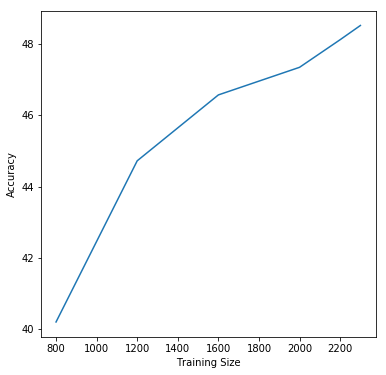

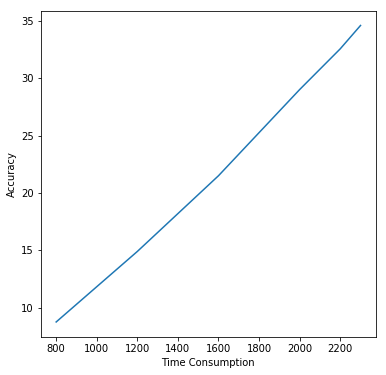

In [48]:
plt.figure(figsize=(6,6))
plt.plot(training_size, Accuracy)
plt.ylabel('Accuracy')
plt.xlabel('Training Size')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(training_size,Time_consum )
plt.ylabel('Accuracy')
plt.xlabel('Time Consumption')
plt.show()

1.   In Figure 1, As the training size increasing, our model is getting better trained. Resultantly, Average Accuracy is increasing with training batch size. So, as the training set size will increase, performance will also increase.

2.   In Figure 2, As the training size increasing, our training time is also increasing. This could be because as size of the batch increased, computation time also increased.


## Performance Report
---
{20 points}
Please report the performance of the following combinations **in the given order**
in terms of the time consumed and classification accuracy. Describe your algorithm,
any decisions you made to write your algorithm in your particular way, and how
different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss
where the method performs best and worse for each of the combination.
Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).<br>
2nd: Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 40-50%). <br>
3rd: Bag of SIFT representation and linear SVM classifier (accuracy of about 50-70%). <br>

Tiny Image Representation + Nearest Neighbor Classifier: 

First I have flattened the images, from 2D to 1D. Then, I have converted the images into unit length and zero mean.
Then using KNeighborsClassifier with n_neighbors = 1,I have trained the model on tiny images. And finally predicted the classes for test set.
Time Consumption in Training (Tiny Image Representation + Nearest Neighbor Classifier) :  0.019340334999998987 seconds
The accuracy of this model is 23.00%
Time Consumption in Prediction (Tiny Image Representation + Nearest Neighbor Classifier) :  0.5613888439999997 seconds




<Figure size 864x864 with 0 Axes>

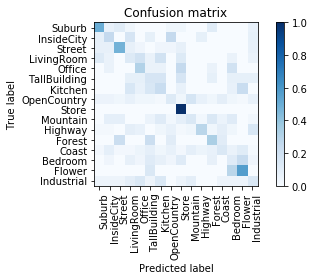

Confusion Matrix Description(Tiny Image Representation + Nearest Neighbor Classifier): 

As we can see diagonal values are small, which indicates less number of correct predictions. Off-diagonal values are not less zeros, indicating wrong prediction of classes.
Best Performed: Store Class.
Worst Performed: Flower images class got wrong classified in Bedroom class which is deducible by looking the correspnding values.


 
Bag of SIFT Representation + Nearest Neighbor Classifier: 

First using dense keypoints corresponding descriptor and KMeans library, I have clustered the features,.Then for each image, I have calculated the histogram.
Then using KNeighborsClassifier with different n_neighbors values like 2,5,10,etc, I have trained the model and predicted the classes for the test set.
The model decent performed for n_neighbors = 10 and n_clusters= 50.
This combination took lesser time consumption in training and prediction as compare to first combination. But clustering took time. I not

<Figure size 864x864 with 0 Axes>

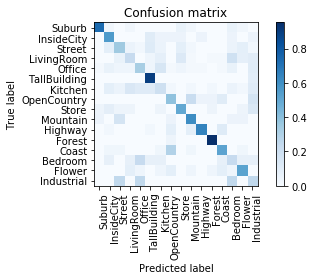

Confusion Matrix Description(Bag of SIFT Representation + Nearest Neighbor Classifier): 

As we can see diagonal values are larger than last combination. Wrong prediction of classes are lesser as compare to last combination.
Best Performed: Forest and TallBuilding Class
Worst Performed: Mostly, Idustrial class Images didn't get classified correct as comapare to other classes.


 
Bag of SIFT Representation + one-vs-all SVMs: 

After standarizing the histogram matrix of images from second combination, I have used LinearSVC with different values of lambda(C) values.I got the best result with Lambda(C) = 4.6.
This combination took least time consumption in training and prediction as compare to rest of the combinations.
Time Consumption in Training (Bag of SIFT Representation + one-vs-all SVMs) :  3.4781483980000303 seconds
The Prediction accuracy of this model is 50.25%
Time Consumption in Prediction (Bag of SIFT Representation + one-vs-all SVMs) :  0.0008427019999999175 seconds


<Figure size 864x864 with 0 Axes>

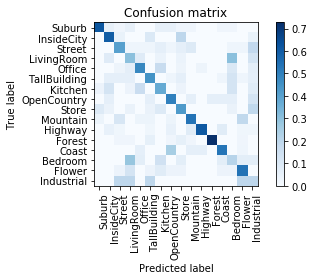

Confusion Matrix Description(Bag of SIFT Representation + one-vs-all SVMs): 

As we can see diagonal values are larger and darker than other combinations. Wrong prediction of classes are lesser as compare to other combinations.
Best Performed: Forest Class
Wrost Performed: Living Room Class Images got classified incorrectly in Bedroom and vice-versa as compare to other classes. This signify the common features of both classes.


 


In [49]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    #fmt = '.2f'
    #thresh = cm.max() / 2.
    #for i in range(cm.shape[0]):
        #for j in range(cm.shape[1]):
            #ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    return ax

c_names = [name[13:] for name in glob.glob('./data/train/*')]

#First combination:
# Confusion matrix
print("Tiny Image Representation + Nearest Neighbor Classifier: \n")
print("First I have flattened the images, from 2D to 1D. Then, I have converted the images into unit length and zero mean.")
print("Then using KNeighborsClassifier with n_neighbors = 1,I have trained the model on tiny images. And finally predicted the classes for test set.")

print("Time Consumption in Training (Tiny Image Representation + Nearest Neighbor Classifier) : ",time1 , "seconds")
print("The accuracy of this model is {:.2f}%".format(accuracy_score(label1,pred1)*100)) 
print("Time Consumption in Prediction (Tiny Image Representation + Nearest Neighbor Classifier) : ",time2, "seconds\n\n")
cm1 = confusion_matrix(pred1, label1)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, c_names, normalize=True)
plt.show()
print("Confusion Matrix Description(Tiny Image Representation + Nearest Neighbor Classifier): \n")
print("As we can see diagonal values are small, which indicates less number of correct predictions. Off-diagonal values are not less zeros, indicating wrong prediction of classes.")
print("Best Performed: Store Class.")
print("Worst Performed: Flower images class got wrong classified in Bedroom class which is deducible by looking the correspnding values.\n\n\n ")

#Second combination:
# Confusion matrix
print("Bag of SIFT Representation + Nearest Neighbor Classifier: \n")
print("First using dense keypoints corresponding descriptor and KMeans library, I have clustered the features,.Then for each image, I have calculated the histogram.") 
print("Then using KNeighborsClassifier with different n_neighbors values like 2,5,10,etc, I have trained the model and predicted the classes for the test set.")
print("The model decent performed for n_neighbors = 10 and n_clusters= 50.")
print("This combination took lesser time consumption in training and prediction as compare to first combination. But clustering took time. I noticed KMeans() library took more time then MiniBatchKMeans()")
print("Time Consumption for Clustering Features: ",time7 , "seconds")
print("Time Consumption for Histogram Generation: ",time8 , "seconds")
print("Time Consumption in Training (Bag of SIFT Representation + Nearest Neighbor Classifer) : ",time3 , "seconds")
print("The Prediction accuracy of this model is {:.2f}%".format(accuracy_score(label2,pred2)*100)) 
print("Time Consumption in Prediction (Bag of SIFT Representation + Nearest Neighbor Classifer) : ",time4 , "seconds")
cm2 = confusion_matrix(pred2, label2)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, c_names, normalize=True)
plt.show()
print("Confusion Matrix Description(Bag of SIFT Representation + Nearest Neighbor Classifier): \n")
print("As we can see diagonal values are larger than last combination. Wrong prediction of classes are lesser as compare to last combination.")
print("Best Performed: Forest and TallBuilding Class")
print("Worst Performed: Mostly, Idustrial class Images didn't get classified correct as comapare to other classes.\n\n\n ")

#Third combination:
# Confusion matrix
print("Bag of SIFT Representation + one-vs-all SVMs: \n")
print("After standarizing the histogram matrix of images from second combination, I have used LinearSVC with different values of lambda(C) values.I got the best result with Lambda(C) = 4.6.")
print("This combination took least time consumption in training and prediction as compare to rest of the combinations.")
print("Time Consumption in Training (Bag of SIFT Representation + one-vs-all SVMs) : ",time5 , "seconds")
print("The Prediction accuracy of this model is {:.2f}%".format(accuracy_score(label3,pred3)*100)) 
print("Time Consumption in Prediction (Bag of SIFT Representation + one-vs-all SVMs) : ",time6 , "seconds")
cm3 = confusion_matrix(pred3, label3)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm3, c_names, normalize=True)
plt.show()

print("Confusion Matrix Description(Bag of SIFT Representation + one-vs-all SVMs): \n")
print("As we can see diagonal values are larger and darker than other combinations. Wrong prediction of classes are lesser as compare to other combinations.")
print("Best Performed: Forest Class")
print("Wrost Performed: Living Room Class Images got classified incorrectly in Bedroom and vice-versa as compare to other classes. This signify the common features of both classes.\n\n\n ")

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw3' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
        |---Surname_Givenname_SBUID_Pred*.txt
```

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw3.zip" for homework3 in this structure:
```
Jordan_Michael_111134567_hw3
        |---Jordan_Michael_111134567_hw3.ipynb
        |---Jordan_Michael_111134567_hw3.pdf
        |---Jordan_Michael_111134567_Pred.txt
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link** and **Surname_Givenname_SBUID_Pred*.pdf** should be your test set prediction file in the specified format. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: ***bo.cao.1@stonybrook.edu*** and ***sayontan.ghosh@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

